In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.sql.functions import col, when, concat, lit, substring, to_date, year, month, ntile, trim
from pyspark.sql.types import FloatType, IntegerType
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.clustering import KMeans
from pyspark.ml.fpm import FPGrowth
from pyspark.ml.evaluation import RegressionEvaluator, BinaryClassificationEvaluator, ClusteringEvaluator




# Create a spark session
spark = SparkSession.builder \
    .appName("NBA Data Analysis Project") \
    .master("spark://spark-master:7077") \
    .config("spark.driver.host", "jupyternb") \
    .config("spark.driver.port", "4040") \
    .config("spark.hadoop.fs.defaultFS", "hdfs://namenode:9000") \
    .getOrCreate()

sc = spark.sparkContext

In [2]:
paths = {
    "game": "hdfs://namenode:9000/nba-data/game.csv",
    "game_info": "hdfs://namenode:9000/nba-data/game_info.csv",
    "game_summary": "hdfs://namenode:9000/nba-data/game_summary.csv",
    "line_score": "hdfs://namenode:9000/nba-data/line_score.csv",
    "other_stats": "hdfs://namenode:9000/nba-data/other_stats.csv",
    "player": "hdfs://namenode:9000/nba-data/player.csv",
    "team": "hdfs://namenode:9000/nba-data/team.csv",
    "team_details": "hdfs://namenode:9000/nba-data/team_details.csv"
}


dfs = {name: spark.read.option("header", True).csv(path) for name, path in paths.items()}

# Show summary
for name, df in dfs.items():
    print(f"{name:<15} | Rows: {df.count():<8} | Cols: {len(df.columns)}")


for name, df in dfs.items():
    for c in df.columns:
        df = df.withColumn(c, trim(col(c)))  # remove leading/trailing spaces
    dfs[name] = df.dropDuplicates()

    
# Cast numeric-like columns
numeric_keywords = [
    "pts", "fg", "ft", "reb", "ast", "stl", "blk", "tov",
    "pf", "plus_minus", "min", "pct", "score"
]

for name, df in dfs.items():
    for c in df.columns:
        if any(k in c.lower() for k in numeric_keywords):
            df = df.withColumn(c, col(c).cast(FloatType()))
        elif "id" in c.lower() or "season" in c.lower():
            df = df.withColumn(c, col(c).cast(IntegerType()))
    dfs[name] = df.fillna(0)  # Replace nulls in numeric columns with 0

# Key filters — remove incomplete records
game_df = dfs["game"].filter(
    col("season_id").isNotNull() &
    col("team_id_home").isNotNull() &
    col("team_id_away").isNotNull()
)

# Create a Win Flag (1 = Win, 0 = Loss)
if "wl" in [c.lower() for c in game_df.columns]:
    game_df = game_df.withColumn(
        "WIN_FLAG",
        when(col("wl") == "W", 1).when(col("wl") == "L", 0).otherwise(None)
    )
    game_df = game_df.filter(col("WIN_FLAG").isNotNull())

dfs["game"] = game_df


# print out schemas
# for name, df in dfs.items():
#     print(f"{name.upper()} SCHEMA:")
#     df.printSchema()


game            | Rows: 65698    | Cols: 55
game_info       | Rows: 58053    | Cols: 4
game_summary    | Rows: 58110    | Cols: 14
line_score      | Rows: 58053    | Cols: 43
other_stats     | Rows: 28271    | Cols: 26
player          | Rows: 4831     | Cols: 5
team            | Rows: 30       | Cols: 7
team_details    | Rows: 25       | Cols: 14


In [3]:
game_df = dfs["game"]
team_details_df = dfs["team_details"]

# Create win flags
game_df = game_df.withColumn(
    "home_win", when(col("wl_home") == "W", 1).when(col("wl_home") == "L", 0)
).withColumn(
    "away_win", when(col("wl_away") == "W", 1).when(col("wl_away") == "L", 0)
)

# Rule: If the month is October or later, the season starts in that year.
# Otherwise, the season started in the previous year.
game_df = game_df.withColumn("parsed_timestamp", col("game_date").cast("timestamp"))
game_df = game_df.withColumn("season_start_year",
    when(month(col("parsed_timestamp")) >= 10, year(col("parsed_timestamp")))
    .otherwise(year(col("parsed_timestamp")) - 1)
)

game_df = game_df.filter(col("season_start_year") >= 1979)

game_df = game_df.withColumn("season_year",
    concat(
        col("season_start_year").cast("string"),
        lit("-"),
        substring((col("season_start_year") + 1).cast("string"), 3, 2)
    )
).drop("parsed_timestamp", "season_start_year")


# Long format: home + away
home_df = game_df.select(
    col("game_id"),
    col("season_id"),
    col("season_year"),
    col("team_id_home").alias("team_id"),
    col("team_name_home").alias("team_name"),
    col("pts_home").alias("points"),
    col("reb_home").alias("rebounds"),
    col("ast_home").alias("assists"),
    col("stl_home").alias("steals"),
    col("blk_home").alias("blocks"),
    col("tov_home").alias("turnovers"),
    col("pf_home").alias("fouls"),
    col("fgm_home").alias("fg_made"),
    col("fga_home").alias("fg_attempted"),
    col("fg_pct_home").alias("fg_pct"),
    col("fg3m_home").alias("fg3_made"),
    col("fg3a_home").alias("fg3_attempted"),
    col("fg3_pct_home").alias("fg3_pct"),
    col("oreb_home").alias("oreb"),
    col("dreb_home").alias("dreb"),
    col("ftm_home").alias("ft_made"),
    col("fta_home").alias("ft_attempted"),
    col("ft_pct_home").alias("ft_pct"),
    col("home_win").alias("win_flag")
)

away_df = game_df.select(
    col("game_id"),
    col("season_id"),
    col("season_year"),
    col("team_id_away").alias("team_id"),
    col("team_name_away").alias("team_name"),
    col("pts_away").alias("points"),
    col("reb_away").alias("rebounds"),
    col("ast_away").alias("assists"),
    col("stl_away").alias("steals"),
    col("blk_away").alias("blocks"),
    col("tov_away").alias("turnovers"),
    col("pf_away").alias("fouls"),
    col("fgm_away").alias("fg_made"),
    col("fga_away").alias("fg_attempted"),
    col("fg_pct_away").alias("fg_pct"),
    col("fg3m_away").alias("fg3_made"),
    col("fg3a_away").alias("fg3_attempted"),
    col("oreb_away").alias("oreb"),
    col("dreb_away").alias("dreb"),
    col("fg3_pct_away").alias("fg3_pct"),
    col("ftm_away").alias("ft_made"),
    col("fta_away").alias("ft_attempted"),
    col("ft_pct_away").alias("ft_pct"),
    col("away_win").alias("win_flag")
)

combined_df = home_df.union(away_df)

# Using groupby to aggregate records
team_season_df = combined_df.groupBy("season_year", "season_id", "team_id", "team_name").agg(
    F.count("*").alias("games_played"),
    F.sum("win_flag").alias("wins"),
    (F.sum("win_flag") / F.count("*")).alias("win_rate"),
    F.avg("points").alias("avg_points"),
    F.avg("rebounds").alias("avg_rebounds"),
    F.avg("assists").alias("avg_assists"),
    F.avg("steals").alias("avg_steals"),
    F.avg("blocks").alias("avg_blocks"),
    F.avg("turnovers").alias("avg_turnovers"),
    F.avg("fouls").alias("avg_fouls")
)

team_season_df = team_season_df.join(team_details_df, on="team_id", how="left")

# Filter to relevant columns and 70+ game seasons
clean_df = team_season_df.select("team_id", "team_name", "season_id", "season_year", "games_played", "wins", "win_rate",
    "avg_points", "avg_rebounds", "avg_assists", "avg_steals", "avg_blocks",
    "avg_turnovers", "avg_fouls", "headcoach", "arena", "arenacapacity"
).filter(col("games_played") >= 70)

# Round numeric columns
numeric_cols = ["win_rate", "avg_points", "avg_rebounds", "avg_assists", "avg_steals",
                "avg_blocks", "avg_turnovers", "avg_fouls"]

for c in numeric_cols:
    clean_df = clean_df.withColumn(c, F.round(col(c), 4))

    
# Display nicely using df
pd.set_option('display.max_columns', None)  
pd.set_option('display.width', 1000)        

# Convert a small sample to Pandas and display it
display_pd = clean_df.limit(15).toPandas()
display_pd

,team_id,team_name,season_id,season_year,games_played,wins,win_rate,avg_points,avg_rebounds,avg_assists,avg_steals,avg_blocks,avg_turnovers,avg_fouls,headcoach,arena,arenacapacity
0,1610612739,Cleveland Cavaliers,22022,2022-23,82,51,0.6220,112.2561,41.0854,24.9390,7.1463,4.6829,13.3415,19.0244,None,None,None
1,1610612750,Minnesota Timberwolves,22002,2002-03,82,51,0.6220,98.1220,43.5732,25.2439,6.7439,5.2805,13.7073,20.7805,Chris Finch,Target Center,19356.0
2,1610612739,Cleveland Cavaliers,22020,2020-21,72,22,0.3056,103.8333,42.7500,23.8333,7.7639,4.5139,15.4722,18.1667,None,None,None
3,1610612739,Cleveland Cavaliers,22004,2004-05,82,42,0.5122,96.5122,42.3049,22.5732,7.9756,5.6220,13.9146,22.5610,None,None,None
4,1610612746,Los Angeles Clippers,22009,2009-10,82,29,0.3537,95.7195,41.8171,22.0732,6.4878,5.6829,15.6707,19.2805,Tyronn Lue,Crypto.com Arena,19060.0
5,1610612746,Los Angeles Clippers,22007,2007-08,82,23,0.2805,93.8049,40.1341,21.1220,6.7927,4.8537,14.3902,21.2805,Tyronn Lue,Crypto.com Arena,19060.0
6,1610612746,Los Angeles Clippers,22003,2003-04,82,28,0.3415,94.7683,43.4756,20.1585,7.2439,4.5854,16.3659,22.1463,Tyronn Lue,Crypto.com Arena,19060.0
7,1610612760,Seattle SuperSonics,21979,1979-80,82,56,0.6829,108.5000,0.0000,0.0000,0.0000,0.0000,0.0000,22.7439,Mark Daigneault,Paycom Center,None
8,1610612760,Oklahoma City Thunder,22017,2017-18,82,48,0.5854,107.8537,45.0610,21.3415,9.0610,5.0244,13.9878,20.1585,Mark Daigneault,Paycom Center,None
9,1610612759,San Antonio Spurs,22017,2017-18,82,47,0.5732,102.7317,44.2195,22.7805,7.6585,5.6098,13.1463,17.1707,Gregg Popovich,AT&T Center,18694.0


generating plot A...


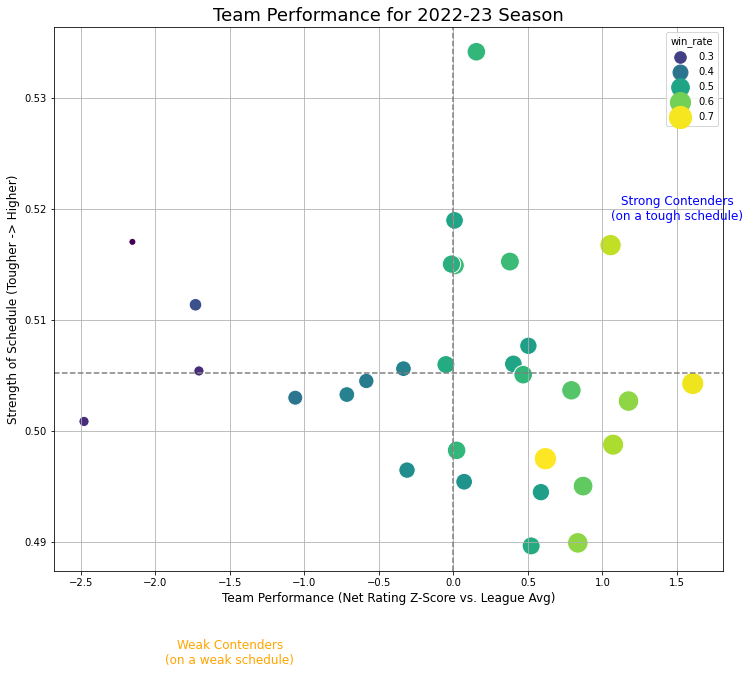

generating plot B...


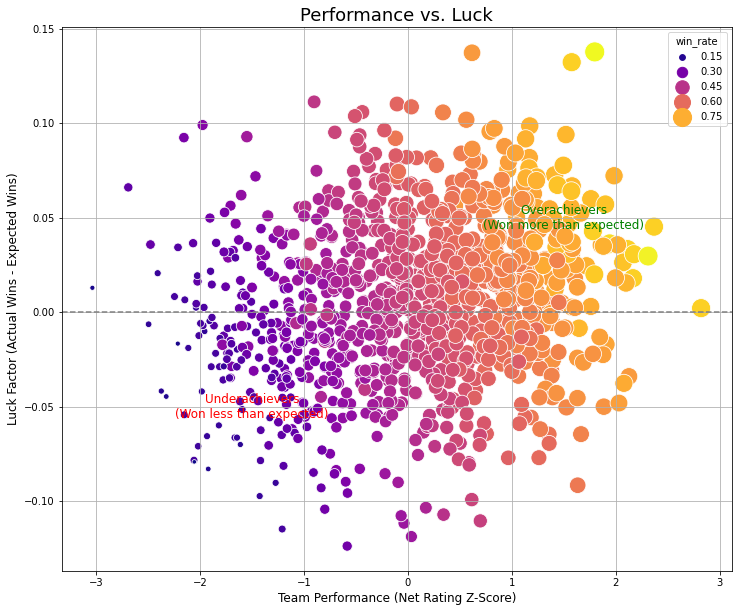

generating plot C...


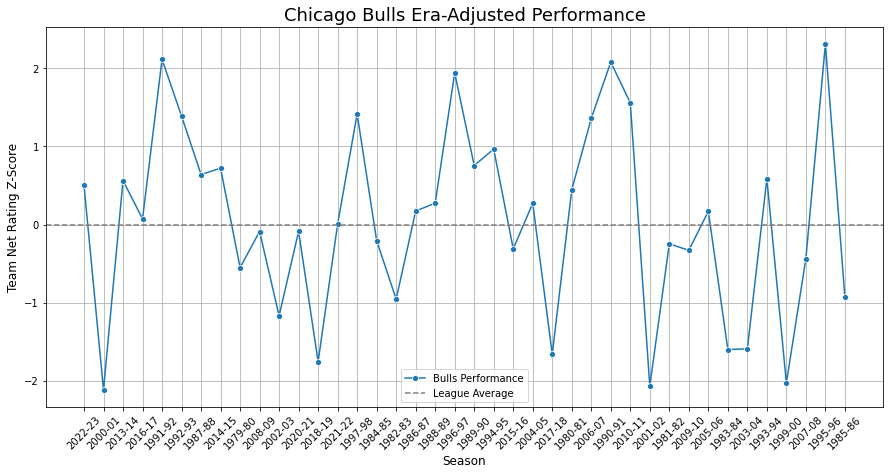

In [4]:

feature_df = clean_df

# 1. Core features; Efficiency (Offensive/Defensive/Net Rating)
opponent_stats = combined_df.select(
    "game_id", "team_id", "fg_attempted", "oreb",
    "turnovers", "ft_attempted", "points"
).alias("opponent")

game_with_opp_stats = combined_df.alias("team").join(
    opponent_stats,
    (col("team.game_id") == col("opponent.game_id")) & (col("team.team_id") != col("opponent.team_id"))
).select(
    col("team.season_year"), col("team.team_id"), col("team.fg_attempted"),
    col("team.oreb"), col("team.turnovers"), col("team.ft_attempted"), col("team.points"),
    col("opponent.fg_attempted").alias("opp_fga"), col("opponent.oreb").alias("opp_oreb"),
    col("opponent.turnovers").alias("opp_tov"), col("opponent.ft_attempted").alias("opp_fta"),
    col("opponent.points").alias("opp_pts")
)

game_with_poss = game_with_opp_stats.withColumn("possessions",
    col("fg_attempted") - col("oreb") + col("turnovers") + (0.475 * col("ft_attempted"))
).withColumn("opp_possessions",
    col("opp_fga") - col("opp_oreb") + col("opp_tov") + (0.475 * col("opp_fta"))
)

ratings_df = game_with_poss.groupBy("season_year", "team_id").agg(
    (F.sum("points") / F.sum((col("possessions") + col("opp_possessions")) / 2) * 100).alias("offensive_rating"),
    (F.sum("opp_pts") / F.sum((col("possessions") + col("opp_possessions")) / 2) * 100).alias("defensive_rating")
)
ratings_df = ratings_df.withColumn("net_rating", col("offensive_rating") - col("defensive_rating"))

feature_df = feature_df.join(ratings_df, on=["season_year", "team_id"], how="left")

# Pyhtagorean Wins
pythag_df = game_with_poss.groupBy("season_year", "team_id").agg(
    F.sum("points").alias("pts_for"),
    F.sum("opp_pts").alias("pts_against")
)

k = 13.91 # Source: /wiki/Pythagorean_expectation Use_in_basketball
pythag_df = pythag_df.withColumn("pythagorean_win_pct",
    (F.pow(col("pts_for"), k)) / (F.pow(col("pts_for"), k) + F.pow(col("pts_against"), k))
)

feature_df = feature_df.join(pythag_df.select("season_year", "team_id", "pythagorean_win_pct"), on=["season_year", "team_id"], how="left")
feature_df = feature_df.withColumn("luck_factor", col("win_rate") - col("pythagorean_win_pct"))


# 2. Era-adjusted Feature: Performance Above League Average (Z-Scores)
season_window = Window.partitionBy("season_year")

league_avg_df = feature_df.withColumn("avg_net_rating_season", F.avg("net_rating").over(season_window)) \
                          .withColumn("std_net_rating_season", F.stddev("net_rating").over(season_window))

feature_df = league_avg_df.withColumn("z_net_rating", (col("net_rating") - col("avg_net_rating_season")) / col("std_net_rating_season"))


# 3. Opponent strength and Context: Strength of Schedule (SoS)
team_season_win_rates = feature_df.select(
    col("season_year").alias("opponent_season_year"),
    col("team_id").alias("opponent_team_id"),
    "win_rate"
)

game_with_opp_id = combined_df.alias("team").join(
    combined_df.select("game_id", "team_id").alias("opponent"),
    (col("team.game_id") == col("opponent.game_id")) & (col("team.team_id") != col("opponent.team_id"))
).select("team.season_year", "team.team_id", col("opponent.team_id").alias("opponent_id"))

game_with_opp_strength = game_with_opp_id.join(
    team_season_win_rates,
    (game_with_opp_id.season_year == team_season_win_rates.opponent_season_year) & \
    (game_with_opp_id.opponent_id == team_season_win_rates.opponent_team_id)
)

strength_of_schedule_df = game_with_opp_strength.groupBy("season_year", "team_id").agg(F.avg("win_rate").alias("strength_of_schedule"))

feature_df = feature_df.join(strength_of_schedule_df, on=["season_year", "team_id"], how="left")



# Visualisation of features
feature_pd = feature_df.toPandas()


# A. Team Performance Quadrant Plot
print("generating plot A...")
season_to_plot = '2022-23'
season_data = feature_pd[feature_pd['season_year'] == season_to_plot]

if not season_data.empty:
    plt.figure(figsize=(12, 10))
    sns.scatterplot(data=season_data, x='z_net_rating', y='strength_of_schedule', hue='win_rate', size='win_rate', sizes=(50, 500), palette='viridis')
    plt.axhline(season_data['strength_of_schedule'].mean(), color='grey', linestyle='--')
    plt.axvline(0, color='grey', linestyle='--')
    plt.title(f'Team Performance for {season_to_plot} Season', fontsize=18)
    plt.xlabel('Team Performance (Net Rating Z-Score vs. League Avg)', fontsize=12)
    plt.ylabel('Strength of Schedule (Tougher -> Higher)', fontsize=12)
    plt.text(1.5, 0.52, 'Strong Contenders\n(on a tough schedule)', ha='center', va='center', fontsize=12, color='blue')
    plt.text(-1.5, 0.48, 'Weak Contenders\n(on a weak schedule)', ha='center', va='center', fontsize=12, color='orange')
    plt.grid(True)
    plt.show()
else:
    print(f"No data found for the season '{season_to_plot}'. FIX ME.")


# B. Team Wins Relative to Expectations
# This plot helps identify which teams performed well or poorly compared to how they should have
print("generating plot B...")
plt.figure(figsize=(12, 10))
sns.scatterplot(data=feature_pd, x='z_net_rating', y='luck_factor', hue='win_rate', size='win_rate', sizes=(20, 400), palette='plasma')
plt.axhline(0, color='grey', linestyle='--')
plt.title('Performance vs. Luck', fontsize=18)
plt.xlabel('Team Performance (Net Rating Z-Score)', fontsize=12)
plt.ylabel('Luck Factor (Actual Wins - Expected Wins)', fontsize=12)
plt.text(1.5, 0.05, 'Overachievers\n(Won more than expected)', ha='center', va='center', fontsize=12, color='green')
plt.text(-1.5, -0.05, 'Underachievers\n(Won less than expected)', ha='center', va='center', fontsize=12, color='red')
plt.grid(True)
plt.show()


# C. Tracking a Franchise over time
# This plot uses our era-adjusted metric to track a team's performance over time.
print("generating plot C...")
if 'team_name' in feature_pd.columns:
    bulls_data = feature_pd[feature_pd['team_name'] == 'Chicago Bulls']

    if not bulls_data.empty:
        plt.figure(figsize=(15, 7))
        bulls_data_filtered = bulls_data[bulls_data['z_net_rating'] != 0] 
        sns.lineplot(data=bulls_data_filtered, x='season_year', y='z_net_rating', marker='o', label='Bulls Performance')
        plt.axhline(0, color='grey', linestyle='--', label='League Average')
        plt.title('Chicago Bulls Era-Adjusted Performance', fontsize=18)
        plt.xlabel('Season', fontsize=12)
        plt.ylabel('Team Net Rating Z-Score', fontsize=12)
        plt.xticks(rotation=45)
        plt.legend()
        plt.grid(True)
        plt.show()
    else:
        print("No data found for the Chicago Bulls. FIX ME.")
else:
    print("'team_name' column not found in feature_df. FIX.")


In [5]:


# Train-test split (using feature_df)
(training_data, test_data) = feature_df.randomSplit([0.8, 0.2], seed=42)
print(f"Training Rows: {training_data.count()} ||| Testing Rows: {test_data.count()}")


Training Rows: 901 ||| Testing Rows: 226


Regression RMSE on Test Data: 0.0431


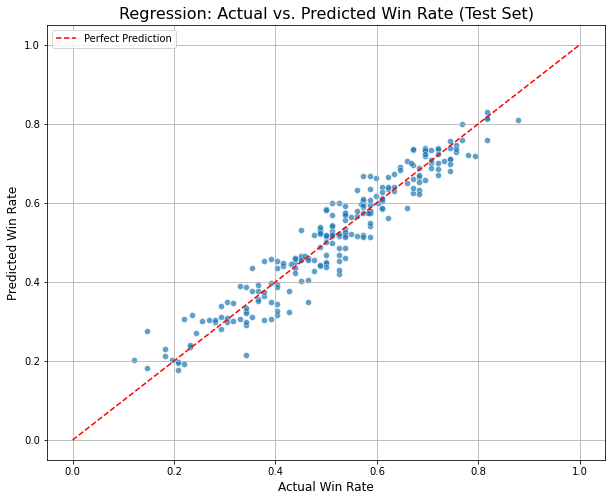

In [6]:

# Model 1 -- Regression
feature_cols = [
    'avg_points', 'avg_rebounds', 'avg_assists', 'avg_steals',
    'avg_blocks', 'avg_turnovers', 'avg_fouls',
    'offensive_rating', 'defensive_rating', 'net_rating',
    'pythagorean_win_pct', 'z_net_rating', 'strength_of_schedule'
]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

gbt = GBTRegressor(featuresCol="features", labelCol="win_rate", maxIter=10)

regression_pipeline = Pipeline(stages=[assembler, gbt])

regression_model = regression_pipeline.fit(training_data)

regression_predictions = regression_model.transform(test_data)

# Model Evaluation
evaluator = RegressionEvaluator(labelCol="win_rate", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(regression_predictions)
print(f"Regression RMSE on Test Data: {rmse:.4f}")

# Visualisation
regression_pd = regression_predictions.select("win_rate", "prediction").toPandas()

plt.figure(figsize=(10, 8))
sns.scatterplot(data=regression_pd, x="win_rate", y="prediction", alpha=0.7)
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Perfect Prediction') # y=x line
plt.title('Regression: Actual vs. Predicted Win Rate (Test Set)', fontsize=16)
plt.xlabel('Actual Win Rate', fontsize=12)
plt.ylabel('Predicted Win Rate', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()



Classification AUC on Test Data: 0.9830


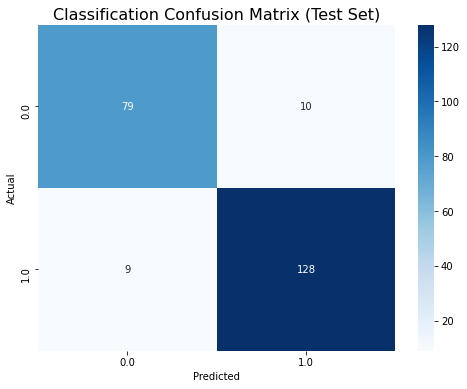

In [7]:
# Model 2 -- Classification
training_data_class = training_data.withColumn("winning_season", (col("win_rate") >= 0.5).cast("double"))

test_data_class = test_data.withColumn("winning_season", (col("win_rate") >= 0.5).cast("double"))

rf = RandomForestClassifier(featuresCol="features", labelCol="winning_season")

classification_pipeline = Pipeline(stages=[assembler, rf])

classification_model = classification_pipeline.fit(training_data_class)

classification_predictions = classification_model.transform(test_data_class)


evaluator = BinaryClassificationEvaluator(labelCol="winning_season")
auc = evaluator.evaluate(classification_predictions)
print(f"Classification AUC on Test Data: {auc:.4f}")

# Confusion Matrix to evaluate Classifier 
preds_and_labels = classification_predictions.select("prediction", "winning_season").toPandas()
confusion_matrix = pd.crosstab(preds_and_labels['winning_season'], preds_and_labels['prediction'], rownames=['Actual'], colnames=['Predicted'])

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Classification Confusion Matrix (Test Set)', fontsize=16)
plt.show()




Silhouette Score: 0.6865


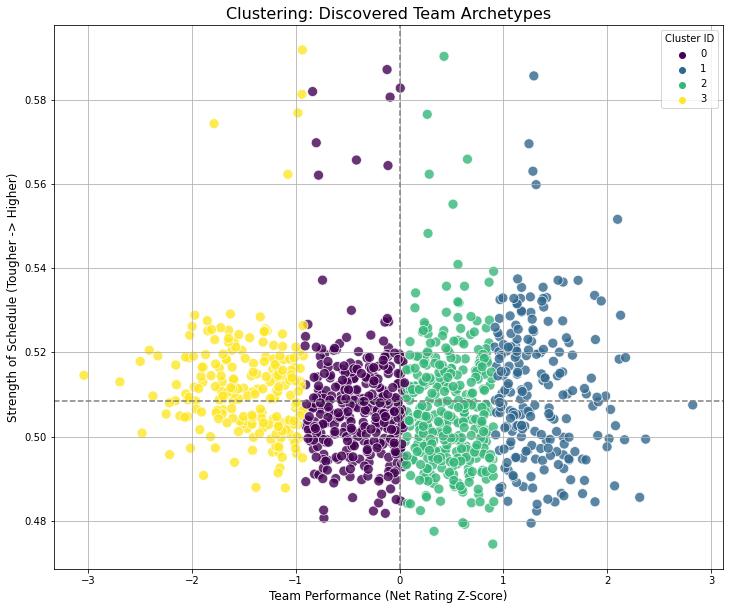

In [8]:
# Task 3 -- Clustering
cluster_assembler = VectorAssembler(inputCols=['z_net_rating', 'strength_of_schedule'], outputCol="cluster_features")

kmeans = KMeans(featuresCol="cluster_features", k=4, seed=1)

clustering_pipeline = Pipeline(stages=[cluster_assembler, kmeans])

clustering_model = clustering_pipeline.fit(feature_df)

clustered_df = clustering_model.transform(feature_df)

evaluator = ClusteringEvaluator(featuresCol='cluster_features', predictionCol='prediction')

silhouette = evaluator.evaluate(clustered_df)
print(f"Silhouette Score: {silhouette:.4f}")

#Clustering Visualization
clustered_pd = clustered_df.select('z_net_rating', 'strength_of_schedule', 'prediction').toPandas()

plt.figure(figsize=(12, 10))
sns.scatterplot(
    data=clustered_pd, 
    x='z_net_rating', 
    y='strength_of_schedule', 
    hue='prediction', 
    palette='viridis', 
    s=100,
    alpha=0.8
)

plt.axhline(clustered_pd['strength_of_schedule'].mean(), color='grey', linestyle='--')
plt.axvline(0, color='grey', linestyle='--')
plt.title('Clustering: Discovered Team Archetypes', fontsize=16)
plt.xlabel('Team Performance (Net Rating Z-Score)', fontsize=12)
plt.ylabel('Strength of Schedule (Tougher -> Higher)', fontsize=12)
plt.legend(title='Cluster ID')
plt.grid(True)
plt.show()

In [9]:
from pyspark.sql import functions as F
from pyspark.sql import types as T
from pyspark.sql.window import Window
from pyspark.ml.fpm import FPGrowth
from pyspark.sql.functions import col

# Create boolean flag: winning season = win_rate >= 0.5
feature_df = feature_df.withColumn("winning_season", col("win_rate") >= 0.5)



# 1. Create quartiles / percentile ranks
percentiles_df = (
    feature_df
    .withColumn("off_rating_quartile", F.ntile(4).over(Window.orderBy(F.col("offensive_rating").desc())))
    .withColumn("def_rating_quartile", F.ntile(4).over(Window.orderBy(F.col("defensive_rating").asc())))
    .withColumn("sos_quartile", F.ntile(4).over(Window.orderBy(F.col("strength_of_schedule").desc())))
)


# Build descriptive "items" array for each team-season
items_df = percentiles_df.withColumn(
    "items",
    # Use the higher-order `filter` function to remove nulls
    F.filter(
        # First create the array with potential nulls
        F.array(
            F.when(F.col("off_rating_quartile") <= 2, F.lit("Top_50_Offense")),
            F.when(F.col("def_rating_quartile") <= 2, F.lit("Top_50_Defense")),
            F.when(F.col("sos_quartile") <= 2, F.lit("Tough_Schedule")),
            F.when(F.col("sos_quartile") >= 3, F.lit("Easy_Schedule")),
            F.when(F.col("winning_season") == True, F.lit("Winning_Season"))
        ),
        # The lambda function keeps an item `x` only if it is not null
        lambda x: x.isNotNull()
    )
)

# 3. FP-Growth Model
fpGrowth = FPGrowth(itemsCol="items", minSupport=0.05, minConfidence=0.3)
fpg_model = fpGrowth.fit(items_df)


# Display rules
print("Association Rules:")
rules = fpg_model.associationRules.orderBy(F.desc("lift"))
rules.show(truncate=False)

Association Rules:
+------------------------------------------------+----------------+------------------+------------------+-------------------+
|antecedent                                      |consequent      |confidence        |lift              |support            |
+------------------------------------------------+----------------+------------------+------------------+-------------------+
|[Top_50_Offense, Tough_Schedule, Top_50_Defense]|[Winning_Season]|1.0               |1.788888888888889 |0.08251996450754215|
|[Top_50_Offense, Top_50_Defense]                |[Winning_Season]|0.9836956521739131|1.7597222222222224|0.160603371783496  |
|[Easy_Schedule, Top_50_Offense, Top_50_Defense] |[Winning_Season]|0.967032967032967 |1.72991452991453  |0.07808340727595386|
|[Tough_Schedule, Winning_Season]                |[Top_50_Offense]|0.7109634551495017|1.4206663367969652|0.1898846495119787 |
|[Easy_Schedule, Winning_Season]                 |[Top_50_Defense]|0.6656534954407295|1.33012675418

Model Evaluation Summary:

The regression model achieved a low RMSE of 0.0431, indicating that predicted performance metrics closely match the actual values, demonstrating high predictive accuracy. Coverting this to wins per NBA season, the regression model is able to predict a team's number of wins within approximately ±3.6 wins.

The classification model produced an AUC of 0.9830, reflecting excellent classification between winning and non-winning seasons. This is further reflected by the confusion matrix.

Clustering results showed a Silhouette Score of 0.6865, suggesting well-defined and meaningful team groupings that capture distinct archetypes based on performance and schedule strength. 

Finally, association rule mining uncovered strong among key performance indicators. E.g. teams that had a top 50% Offense and Defense with a tough schedule had a 100% likelihood of a winning season and were thant 1.79x more likely to win than average, with several rules exhibiting high confidence and lift values.

Collectively, these results confirm that the models provide reliable, data-driven insights into team success factors and competitive dynamics.